In [16]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

import cmocean
import plot_tools
import proc_cesm_le

In [17]:
files = sorted(glob(os.path.join(diro['out'],'volume_timeseries.ann_dft.ens_i_???.nc')))
ds = []
for i,f in enumerate(files):
    dsi = xr.open_dataset(f,decode_times=False,decode_coords=False)
    dsi = dsi.drop([v for v in dsi if v not in ['V5INT','V50INT','V60INT']])    
    ds.append(dsi)
ds = xr.concat(ds,dim='ens')
ds['time'] = xr.DataArray(np.arange(1920,2101,1),dims=('time'))
print ds

<xarray.Dataset>
Dimensions:  (ens: 33, time: 181)
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 ...
Dimensions without coordinates: ens
Data variables:
    V60INT   (ens, time) float64 1.077e+17 1.077e+17 1.077e+17 1.076e+17 ...
    V50INT   (ens, time) float64 8.847e+16 8.835e+16 8.829e+16 8.824e+16 ...
    V5INT    (ens, time) float64 1.602e+16 1.584e+16 1.606e+16 1.608e+16 ...
Attributes:
    history:  Mon Oct 23 10:27:00 2017: ncks -O -4 tr85.001.ann_dft.O2.1920-2...
    NCO:      4.6.7


### compute ensemble mean of CESM-LE

In [18]:
dsa = ds.mean(dim='ens')
dss = ds.std(dim='ens')

cesm_baseline = dsa.sel(time=slice(1920,1939)).mean(dim='time')
print cesm_baseline

dsa = dsa - cesm_baseline
dsa

<xarray.Dataset>
Dimensions:  ()
Data variables:
    V60INT   float64 1.076e+17
    V50INT   float64 8.825e+16
    V5INT    float64 1.605e+16


<xarray.Dataset>
Dimensions:  (time: 181)
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 ...
Data variables:
    V60INT   (time) float64 1.596e+14 1.009e+14 9.302e+13 2.176e+13 ...
    V50INT   (time) float64 1.974e+14 1.66e+14 9.211e+13 1.923e+13 ...
    V5INT    (time) float64 -5.552e+13 -9.851e+13 2.087e+13 2.104e+13 ...

### load CMIP data

In [19]:
files = ['IUCN_v5ts.nc','IUCN_v60ts.nc']
files = ['data/'+f for f in files]
cmip = xr.open_mfdataset(files)
cmip = cmip.rename({'TIME1':'time'})
cmip['V60INT'] = cmip.V50INT
cmip = cmip.drop('V50INT')
cmip['time'] = xr.DataArray(np.arange(1861,2101,1),dims=('time'))
cmip = cmip.sel(time=slice(1920,2100))

cmip_baseline = cmip.sel(time=slice(1920,1939)).mean(dim='time')
print cmip_baseline

cmip = cmip - cmip_baseline
cmip

<xarray.Dataset>
Dimensions:  ()
Data variables:
    V5INT    float64 1.585e+16
    V60INT   float64 7.738e+16


<xarray.Dataset>
Dimensions:  (time: 181)
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 ...
Data variables:
    V5INT    (time) float64 9.867e+13 1.582e+14 -1.076e+13 -6.251e+12 ...
    V60INT   (time) float64 6.855e+13 -3.016e+13 -6.981e+13 -4.122e+13 ...

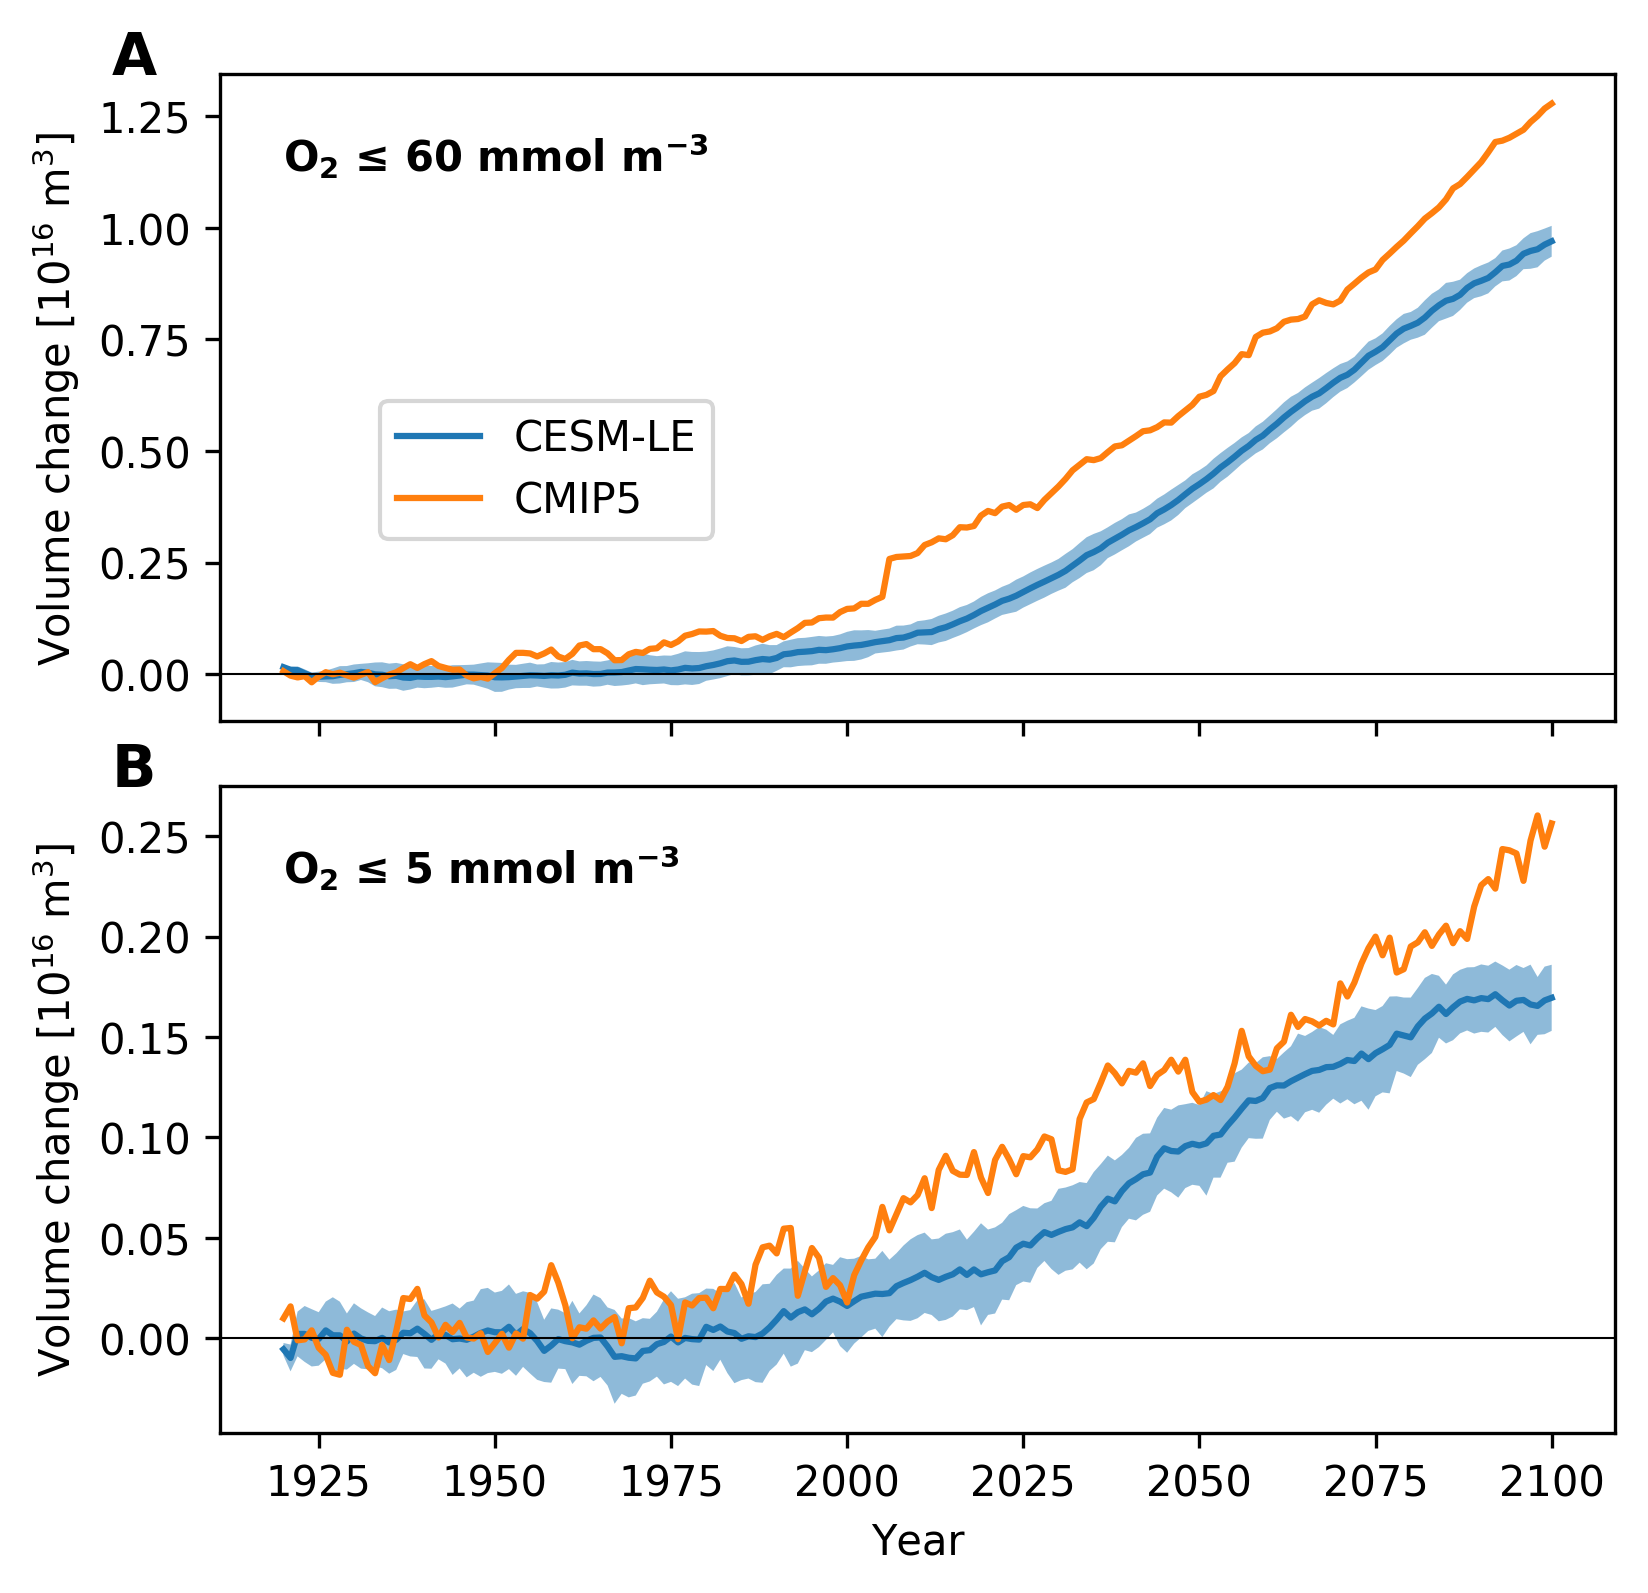

In [21]:
plot_name = os.path.join(diro['fig'],'volume-census.pdf')
fig = plt.figure(figsize=(6,6),dpi=300)

gs = gridspec.GridSpec(2,1)

label = {'V60INT': u'O$_2$ ≤ 60 mmol m$^{-3}$',
         'V50INT': u'O$_2$ ≤ 50 mmol m$^{-3}$',
         'V5INT': u'O$_2$ ≤ 5 mmol m$^{-3}$'}
for i,v in enumerate(['V60INT','V5INT']):
    ax = fig.add_subplot(gs[i,0])
    
    ax.fill_between(ds.time,(dsa[v]-dss[v])*1e-16,(dsa[v]+dss[v])*1e-16,alpha=0.5)
    ax.plot(ds.time,dsa[v]*1e-16,label='CESM-LE')
    ax.plot(cmip.time,cmip[v]*1e-16,label='CMIP5')
    ylm = ax.get_ylim()
    
    ax.text(1920,ylm[1]-0.15*np.diff(ylm),label[v],fontweight='bold')
    ax.set_ylabel('Volume change [10$^{16}$ m$^{3}$]')

    ax.axhline(0,linewidth=0.5,color='black')


axs = fig.get_axes()
axs[0].set_xticklabels([])
axs[-1].set_xlabel('Year')

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, labels,bbox_to_anchor=(0.1,0.25))

gs.update(hspace=0.1)

alp = [chr(i).upper() for i in range(97,97+26)]
for i,ax in enumerate(axs):
    p = ax.get_position()
    y = p.y1+0.00
    x = p.x0-0.06
    fig.text(x,y,'%s'%alp[i],
             fontsize=14.,
             fontweight = 'semibold')
    
plt.savefig(plot_name,bbox_inches='tight')

In [25]:
dsa.isel(time=-1)/cesm_baseline

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     int64 2100
Data variables:
    V60INT   float64 0.09012
    V50INT   float64 0.1099
    V5INT    float64 0.1056

In [26]:
cmip.isel(time=-1)/cmip_baseline

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     int64 2100
Data variables:
    V5INT    float64 0.1617
    V60INT   float64 0.1652

In [24]:
1/8.8

0.11363636363636363